In [1]:
from psycopg2 import connect, extras
import numpy as np
import datetime
import pandas as pd
import glob,os
from matplotlib import pyplot as plt

In [2]:
'''Need to clone chris m's visual behavior code
    located here: https://github.com/mochic/visual_behavior_analysis.git
    Then change path below to point to visual_behavior repo
'''

%cd "C:\Users\taminar\Documents\GitHub\visual_behavior_analysis"
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

C:\Users\taminar\Documents\GitHub\visual_behavior_analysis


**setup sql connection/cursor to get data from lims**

In [3]:
con = connect(
    dbname='lims2',
    user='limsreader',
    host='limsdb2',
    password='limsro',
    port=5432,
)

con.set_session(
    readonly=True, 
    autocommit=True,
)

cursor = con.cursor(
    cursor_factory=extras.RealDictCursor,
)

In [4]:
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cursor.fetchall():
    print(table)

RealDictRow([('table_name', 'artifacts')])
RealDictRow([('table_name', 'stimuli')])
RealDictRow([('table_name', 'well_known_file_hashes')])
RealDictRow([('table_name', 'visual_behavior_container_runs')])
RealDictRow([('table_name', 'ecephys_channels')])
RealDictRow([('table_name', 'sectioning_tasks')])
RealDictRow([('table_name', 'executables_genotypes')])
RealDictRow([('table_name', 'mfish_tubes')])
RealDictRow([('table_name', 'stimulus_namespaces')])
RealDictRow([('table_name', 'artifact_namespaces')])
RealDictRow([('table_name', 'ecephys_unit_metric_bundles')])
RealDictRow([('table_name', 'dendrite_types')])
RealDictRow([('table_name', 'ecephys_subprocessors')])
RealDictRow([('table_name', 'ephys_qc_criterias')])
RealDictRow([('table_name', 'calculatedilutions_v')])
RealDictRow([('table_name', 'slides')])
RealDictRow([('table_name', 'cdna_primer_report_views')])
RealDictRow([('table_name', 'code_books')])
RealDictRow([('table_name', 'ecephys_analysis_run_probes')])
RealDictRow([('ta

In [6]:
def getLimsID(mouse_id):
    query_template = '''
    SELECT * 
    FROM donors d
    WHERE d.external_donor_name = '{}'
    '''

    cursor.execute(query_template.format(mouse_id))
    lims_id = cursor.fetchone()['id']
    return lims_id

def getBehaviorSessionsFromLimsID(lims_id):
    query_template = '''
    SELECT *
    FROM behavior_sessions bs
    WHERE bs.donor_id = {}
    '''

    cursor.execute(query_template.format(lims_id))
    behavior_sessions = pd.DataFrame(cursor.fetchall())
    return behavior_sessions

def getBehaviorSessionsForMouse(mouse_id):
    lims_id = getLimsID(mouse_id)
    return getBehaviorSessionsFromLimsID(lims_id)

def getPicklePath(storage_directory):
    if storage_directory[1] != '/':
        storage_directory = '/' + storage_directory
    pp = glob.glob(os.path.join(storage_directory, '*.pkl'))
    if len(pp)>0:
        return pp[0]
    else:
        return None
    
def getTrialsDF(pklpath):
    p = pd.read_pickle(pklpath)
    if 'behavior' in p['items']:
        core_data = data_to_change_detection_core(p)
        trials = create_extended_dataframe(
                trials=core_data['trials'],
                metadata=core_data['metadata'],
                licks=core_data['licks'],
                time=core_data['time'])
    else:
        print('Found non-behavior pickle file: ' + pklpath)
        trials = pd.DataFrame.from_dict({'stage':[None]})
    return trials
    

**pull behavior sessions for a given mouse into pandas dataframe**

In [10]:
mouse_id = '487461'
beh_sessions = getBehaviorSessionsForMouse(mouse_id)

#add common rig name
beh_sessions['rig'] = beh_sessions.apply(lambda row: 
        pd.read_sql('select * from equipment where id = {}'.format(row['equipment_id']), con)['name'], axis=1)

#add pkl file paths
beh_sessions['pklfile'] = beh_sessions.apply(lambda row: 
        getPicklePath(row['storage_directory']), axis=1)

In [11]:
beh_sessions.head()

,id,behavior_training_id,created_at,updated_at,storage_directory,temp_output_file_location,foraging_id,donor_id,ophys_session_id,equipment_id,user_id,rig,pklfile
0,989163718,None,2019-11-22 00:30:58.241549,2019-11-22 00:30:59.015704,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,cecf82fc998f47cebb80f8b3571bd6fb,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...
1,989140241,None,2019-11-21 23:25:57.042192,2019-11-21 23:25:57.544426,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,ff93d726a1894982970517528cac0ce9,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...
2,989137403,None,2019-11-21 23:00:56.364810,2019-11-21 23:00:57.472562,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,793d4bdc9a7b4f3fb42c396d3f6345a6,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...
3,988253253,None,2019-11-21 00:40:53.289655,2019-11-21 00:40:53.829357,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,aa6d4e4971594702ab2c0197d5494cdb,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...
4,988177938,None,2019-11-20 23:41:01.265513,2019-11-20 23:41:01.691865,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,ee579b33de9b4b41b9374c66d18d8a04,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...


In [14]:
#pick out dates to analyze: it takes a bit of time to pull this data from the network, so limiting your
#dates is helpful when possible
startDate = '2019-11-20'
endDate = '2020'
toAnalyze = beh_sessions[(beh_sessions['created_at']>=startDate)&(beh_sessions['created_at']<endDate)]

In [15]:
toAnalyze['trials'] = toAnalyze.apply(lambda row: getTrialsDF(row['pklfile']), axis=1) #this trials object has all the info you need about the session
toAnalyze['stage'] = toAnalyze.apply(lambda row: row['trials']['stage'][0], axis=1) #add the training stage to the dataframe
toAnalyze = toAnalyze.loc[toAnalyze['stage'].notnull()] #filter out the passive pickle files that get added during recordings

Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_940732891/behavior_session_989163718\cecf82fc998f47cebb80f8b3571bd6fb.pkl
Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_940732891/behavior_session_989163718\cecf82fc998f47cebb80f8b3571bd6fb.pkl
Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_940732891/behavior_session_989140241\ff93d726a1894982970517528cac0ce9.pkl
Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_940732891/behavior_session_988253253\aa6d4e4971594702ab2c0197d5494cdb.pkl
Found non-behavior pickle file: //allen/programs/braintv/production/visualbehavior/prod0/specimen_940732891/behavior_session_988177938\ee579b33de9b4b41b9374c66d18d8a04.pkl


C:\Users\taminar\AppData\Local\Continuum\anaconda3\envs\lims\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\taminar\AppData\Local\Continuum\anaconda3\envs\lims\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
toAnalyze

,id,behavior_training_id,created_at,updated_at,storage_directory,temp_output_file_location,foraging_id,donor_id,ophys_session_id,equipment_id,user_id,rig,pklfile,trials,stage
2,989137403,None,2019-11-21 23:00:56.364810,2019-11-21 23:00:57.472562,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,793d4bdc9a7b4f3fb42c396d3f6345a6,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...,index auto_rewarded change_contrast chan...,EPHYS_1_images_B_low_volume
5,988143231,None,2019-11-20 23:11:05.803281,2019-11-20 23:11:07.520254,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/incoming/vi...,69c297d4dcf14446a36574dda6dea7d4,940732881,None,677098835,704511589,NP.0,//allen/programs/braintv/production/visualbeha...,index auto_rewarded change_contrast chan...,EPHYS_1_images_A_low_volume


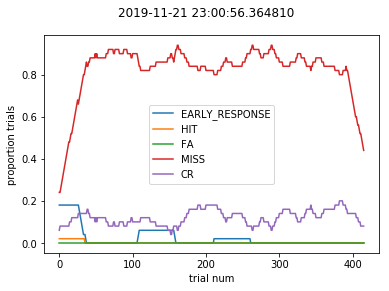

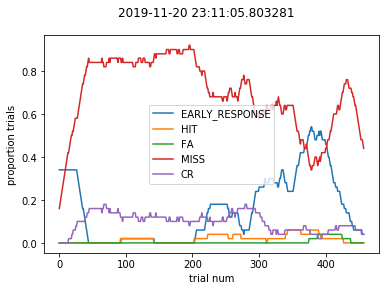

In [17]:
#plot proportion of trials that were aborts, hits and false alarms
for ir, row in toAnalyze.iterrows():
    fig, ax = plt.subplots()
    fig.suptitle(row['created_at'])
    [ax.plot(np.convolve(np.ones(50), row['trials']['response_type']==r, 'same')/50) for r in ['EARLY_RESPONSE', 'HIT', 'FA', 'MISS', 'CR']]
    ax.set_xlabel('trial num')
    ax.set_ylabel('proportion trials')
    ax.legend(['EARLY_RESPONSE', 'HIT', 'FA', 'MISS', 'CR'])
    

In [5]:
#plot proportion of trials that were aborts, hits and false alarms
for ir, row in toAnalyze.iterrows():
    fig, ax = plt.subplots()
    fig.suptitle(row['created_at'])
    ax.plot(np.convolve(np.ones(50), row['trials']['response_type']=='EARLY_RESPONSE', 'same')/50)
    ax2 = ax.twinx()
    ax2.plot(row['trials']['reward_rate'])
    ax.set_xlabel('trial num')
    ax.set_ylabel('proportion trials')
    
    

NameError: name 'toAnalyze' is not defined